In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle

import torch
device = torch.device("cuda:2" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

import sys
sys.path.append("..")
import models
import h5py
import data
import inference


%load_ext autoreload
%autoreload 2

In [2]:
fs = 50
dx = 4

f_in = h5py.File('../data/melbourne_data/d50Hz_b10_UTC_20220226_104502.106.h5', 'r')
DAS_data = f_in['DAS'][:]   #DAS data  (time x channels)

npts = DAS_data.shape[0]
nchan = DAS_data.shape[1]

# convert channel to distance
# find distance / channel number
SpatialResolution = float(f_in['DAS'].attrs['SpatialResolution[m]'].decode('latin-1'))
FibreLengthMultiplier = float(f_in['DAS'].attrs['Fibre Length Multiplier'].decode('latin-1'))
ZeroOffset = float(f_in['DAS'].attrs['Zero Offset (m)'].decode('latin-1'))
Fibre_step = SpatialResolution * FibreLengthMultiplier
distance_list = np.multiply(range(0, nchan), Fibre_step) + ZeroOffset
distance_list = np.around(distance_list, decimals=2)  # in meters

dt_decimate =  float(f_in['DAS'].attrs['V_dt_decimate'])
decimation_factor = f_in['DAS'].attrs['V_decimation_factor']
samplingfrequency = float(f_in['DAS'].attrs['SamplingFrequency[Hz]'].decode('latin-1')) / decimation_factor
dt_decimate, decimation_factor, samplingfrequency, np.argmax(distance_list >= 0)

(0.016, 16, 62.5, 81)

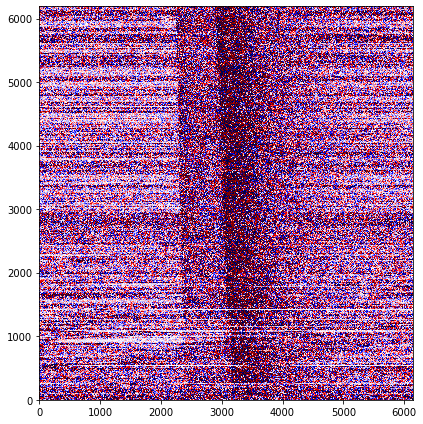

In [3]:
idx = 3600
x = np.hstack([h5py.File('../data/melbourne_data/d50Hz_b10_UTC_20220226_104502.106.h5')['DAS'][:].T,
               h5py.File('../data/melbourne_data/d50Hz_b10_UTC_20220226_104602.106.h5')['DAS'][:].T,])[81:,idx-3072:idx+3072]

gutter = 1000
x = np.pad(x[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
x = x / x.std(axis=-1, keepdims=True)

np.save('../data/melbourne_input.npy', x)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,6))
ax.imshow(x, origin='lower', interpolation='nearest', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

In [4]:
if not os.path.isfile('../data/melbourne_output.npy'):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-finetuned4-complement-128x512-16x180_200.pt'))
    model.eval()

    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 128, 512, 16, nx_stride=6, nt_stride=50, batch_size=128, dx=4, verbose=False)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/melbourne_output.npy', rec_filt)

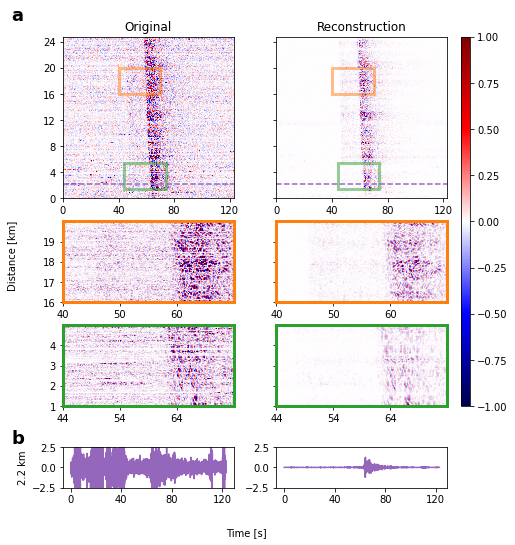

In [5]:
xx = np.load('../data/melbourne_output.npy')
x1, y1 = 2000, 16000 // 4
x2, y2 = 2200, 1500 // 4
w, h = 1500, 4000 // 4

lw = 3
alpha = 0.5

vmin = -1
vmax = 1

fig, axs = plt.subplot_mosaic([['a', 'a', 'a', 'b', 'b', 'b'], 
                               ['a', 'a', 'a', 'b', 'b', 'b'], 
                               ['a', 'a', 'a', 'b', 'b', 'b'], 
                               ['a', 'a', 'a', 'b', 'b', 'b'], 
                               ['c', 'c', 'c', 'd', 'd', 'd'], 
                               ['c', 'c', 'c', 'd', 'd', 'd'], 
                               ['e', 'e', 'e', 'f', 'f', 'f',],
                               ['e', 'e', 'e', 'f', 'f', 'f',],
                               ['a1', 'a1', 'a1', 'b1', 'b1', 'b1']],
                               layout='constrained', figsize=(7,7))

im = axs['a'].imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['a'].set_title('Original')
im = axs['b'].imshow(xx, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['b'].set_title('Reconstruction')
axs['a'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['b'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['a'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['b'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['c'].imshow(x[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['d'].imshow(xx[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['e'].imshow(x[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['f'].imshow(xx[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)

fig.colorbar(im, ax=[axs['b'], axs['d'], axs['f']], location='right', shrink=1, aspect=40, pad=0.05)
axs['c'].set_xticks([i for i in range(0,w,500)])
axs['d'].set_xticks([i for i in range(0,w,500)])
axs['e'].set_xticks([i for i in range(0,w,500)])
axs['f'].set_xticks([i for i in range(0,w,500)])

axs['a'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x * 4 * 0.001))}')) # 4.083809535485629
axs['a'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
axs['b'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))

axs['c'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y1) * 4 * 0.001))}'))
axs['e'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y2) * 4 * 0.001))}'))
axs['c'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['d'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['e'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))
axs['f'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))

axs['a1'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
axs['b1'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))

for a in ['c', 'd']:
    for b in ['bottom', 'top', 'right', 'left']:
        axs[a].spines[b].set_color('tab:orange')
        axs[a].spines[b].set_linewidth(lw)
for a in ['e', 'f']:
    for b in ['bottom', 'top', 'right', 'left']:
        axs[a].spines[b].set_color('tab:green')
        axs[a].spines[b].set_linewidth(lw)

axs['b'].set_yticklabels([])
axs['d'].set_yticklabels([])
axs['f'].set_yticklabels([])

ch1 = 2250 // 4

axs['a'].axhline(ch1, ls="--", c="tab:purple")
axs['b'].axhline(ch1, ls="--", c="tab:purple")

axs['a1'].plot(x[ch1], color='tab:purple')
axs['b1'].plot(xx[ch1], color='tab:purple')
axs['a1'].set_ylabel("{:.1f} km".format(ch1*dx / 1000))

axs['a1'].set_ylim((-2.5,2.5))
axs['b1'].set_ylim((-2.5,2.5))

fig.text(0, 0.5, 'Distance [km]', ha='left', va='center', rotation='vertical')
fig.text(0.475, -0.05, 'Time [s]', ha='center', va='center')

axs['a'].text(-0.3, 1.1, 'a', transform=axs['a'].transAxes, size=18, weight='bold')
axs['a1'].text(-0.3, 1.1, 'b', transform=axs['a1'].transAxes, size=18, weight='bold')

plt.savefig('./out/figure_A2.pdf', bbox_inches='tight', dpi=200)
plt.show()